https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

In [7]:
import utilities

In [8]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = io.open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 600893
total chars: 57


In [9]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 200285


In [10]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [11]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_2 (Dense)              (None, 57)                7353      
_________________________________________________________________
activation_2 (Activation)    (None, 57)                0         
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
utilities.print_weights_shape(model)

-------------
(57, 512)
(128, 512)
(512,)
-------------
(128, 57)
(57,)
-------------


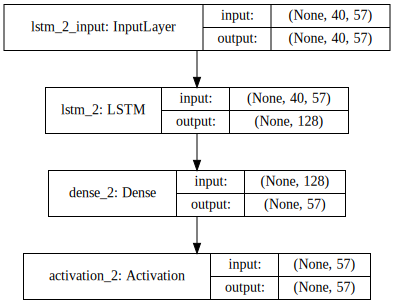

In [13]:
utilities.plot_keras_model(model)

In [15]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
 97152/200285 [=============>................] - ETA: 24s - loss: 1.3011

KeyboardInterrupt: 